require(MetaVolcanoR)
require(ggplot2)
require(ggrepel)
require(biomaRt)
require(msigdbr)
require(clusterProfiler)


library(enrichplot)
require(cowplot)
require(dplyr)
require(SuperExactTest)

In [2]:
NUM_CELLS_THRESH = 100
PERCENT_UNIQUE_THRESH = 0.05
PERCENT_UNSATURATED_TARGETS_THRESH = 0.2

data_directory = "/WorkDir4/yanzeqin/220823_A00403_0863_AHMNGLDSX3/Script/AP-data/"
tumor_clone_statistics = read.table(paste0(data_directory, "/allele/tumor_statistics.tsv"), sep='\t', header=T, row.names=1)


filt.tumors = rownames(subset(tumor_clone_statistics, NumCells < NUM_CELLS_THRESH | 
                              PercentUnique <= PERCENT_UNIQUE_THRESH |
                              PercentUnsaturatedTargets <= PERCENT_UNSATURATED_TARGETS_THRESH))

SyntaxError: keyword can't be an expression (163568521.py, line 6)

## Read in DE results

Differential expression tests were performed with the julia script `./scripts/run_tumor_regressions.jl` and log2FCs were computed using `./scripts/compute_log2fc.jl`. Dataframes from both scritps were joined together and p-values were FDR corrected.

In [4]:
# form fitness observations
tumor_list = read.table(paste0(data_directory, "/trees/tumor_list.txt"), sep='\t', header=T, row.names=1, stringsAsFactors = F)$Tumors

de.results = list()

beta.df = data.frame()

home.dir = paste0(data_directory, "/trees")
for (tumor in tumor2model) {
    
    if (tumor %in% filt.tumors) {
        next;
    }
    
    tumor.type = unlist(strsplit(tumor, "_", fixed=T))[[3]]
    
    if (!grepl('T', tumor.type, fixed=T)) {
        next;
    }
    
    if (grepl('NT', tumor, fixed=T) && !grepl('Fam', tumor, fixed=T) && !grepl("Met", tumor, fixed=T)) {
    
        gene.fp = paste(home.dir, tumor, paste0("linregress.", tumor, ".log2fc.txt"), sep="/")
        
        if (file.exists(gene.fp)) {
        
            res = read.table(gene.fp, sep='\t', header=T)
            
            if (!'genes' %in% colnames(res)) {
                res$genes = res$X
            }

            de.results[[tumor]] = res
        }
    }
}

### Figure 3B - Plot DE results from a single tumor

[1] 1796    9
[1] 1501    9


Warning message:
“ggrepel: 158 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


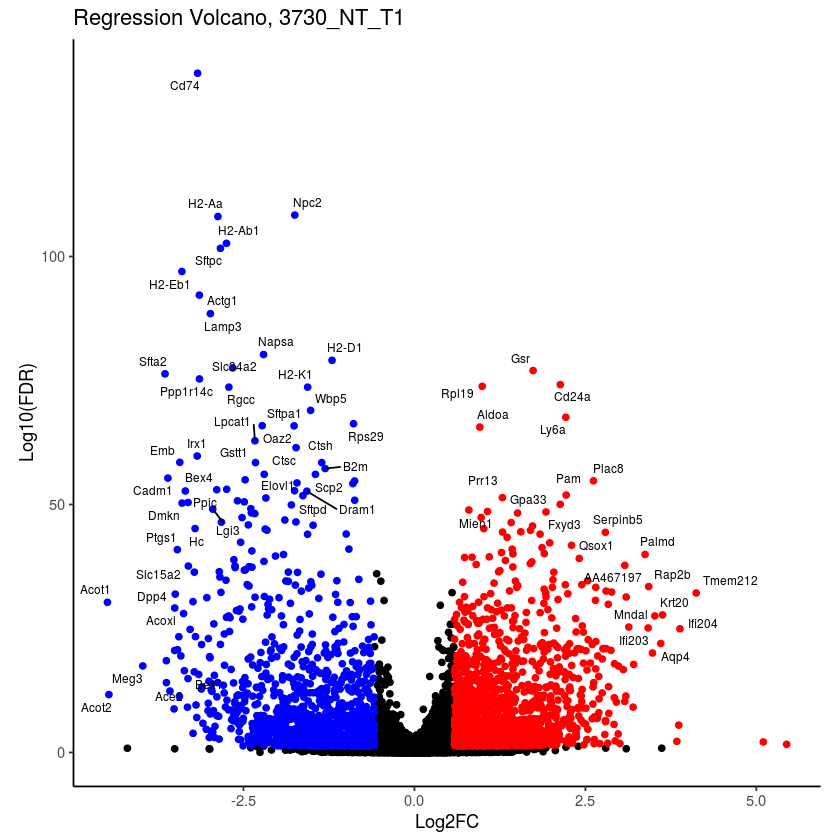

In [5]:
tumor = '3730_NT_T1'
fp = paste0(home.dir, "/linregress.", tumor, ".log2fc.txt")

LOG2FC = log2(1.5)
FDR_THRESH = 0.05

savefig = FALSE

DISC_THRESH = 50

genes.df = read.table(fp, sep='\t', header=T)
genes.df$log10qval = -log10(genes.df$FDR)

# remove genes whose pvalue is 0
genes.df[is.infinite(genes.df$log10qval),"log10qval"] = 300
genes.df$log10qval = unlist(lapply(genes.df$log10qval, function(x) min(300, x)))
                                
genes.df$disc = apply(genes.df, 1, function(x) as.numeric(x["log10qval"]) * abs(as.numeric(x["log2fc"])))                              


hits = genes.df[genes.df$disc >= DISC_THRESH, ]
hit.genes = hits$genes

pos = hits[hits$log2fc >= 0, ]
neg = hits[hits$log2fc < 0, ]

pos.ordered = pos[order(-pos$disc), ]
neg.ordered = neg[order(-neg$disc), ]
                      

pos.genes = as.character(pos.ordered$genes)[1:20]
neg.genes = as.character(neg.ordered$genes)[1:20]
                      
print(dim(subset(genes.df, log2fc > LOG2FC & FDR < FDR_THRESH)))
print(dim(subset(genes.df, log2fc < -1*LOG2FC & FDR < FDR_THRESH)))

                            
ggplot(genes.df, aes(log2fc, log10qval, label=genes)) + 
  geom_point(data = subset(genes.df, abs(log2fc) < LOG2FC | FDR >= FDR_THRESH), color='black') +
  geom_point(data = subset(genes.df, log2fc > LOG2FC & FDR < FDR_THRESH), color='red') + 
  geom_point(data = subset(genes.df, log2fc < -1*LOG2FC & FDR < FDR_THRESH), color='blue') +
  geom_text_repel(data = subset(genes.df, genes %in% hit.genes), size = 2.5) + 
  labs(x = 'Log2FC', y = 'Log10(FDR)', title = paste0('Regression Volcano, ', tumor)) +
  theme_classic() + theme(aspect.ratio = 1)


### Figure 3C - Majority Vote Analysis

In [6]:
meta_degs_vc <- votecount_mv(diffexp=de.results,
                   pcriteria='FDR', 
                   foldchangecol='log2fc',
                   genenamecol='genes',
                   pvalue=0.05,
                   foldchange=log2(1.5),
                   metathr=0.01,
                   collaps=T,
                   jobname='MetaVolcano',
                   outputfolder='.',
                   draw='PDF')

Warning message:
“Continuous limits supplied to discrete scale.
Did you mean `limits = factor(...)` or `scale_*_continuous()`?”
Warning message:
“Continuous limits supplied to discrete scale.
Did you mean `limits = factor(...)` or `scale_*_continuous()`?”


In [7]:
res = meta_degs_vc@metaresult

head(res)

,genes,deg_1,deg_2,deg_3,deg_4,deg_5,deg_6,deg_7,deg_8,deg_9,⋯,deg_16,deg_17,deg_18,deg_19,deg_20,deg_21,ndeg,ddeg,idx,degvcount
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,Lyz2,-1,-1,-1,0,-1,0,-1,0,-1,⋯,0,-1,-1,0,-1,-1,14,-14,-196,0.Down-regulated
2,Sftpa1,-1,-1,-1,0,-1,0,-1,0,-1,⋯,0,-1,-1,0,-1,-1,14,-14,-196,0.Down-regulated
3,Cxcl15,-1,-1,-1,0,-1,0,-1,0,-1,⋯,0,-1,-1,0,-1,-1,13,-13,-169,0.Down-regulated
4,Scd1,-1,0,-1,0,-1,0,-1,0,-1,⋯,0,-1,-1,0,-1,-1,13,-13,-169,0.Down-regulated
5,Sftpc,-1,-1,-1,0,-1,0,-1,0,0,⋯,0,-1,-1,0,-1,-1,13,-13,-169,0.Down-regulated
6,H2-D1,-1,0,0,0,-1,0,-1,0,-1,⋯,0,-1,-1,0,-1,-1,12,-12,-144,0.Down-regulated


[1] "Found 1183 up-regulated genes and 1027 down-regulated genes."


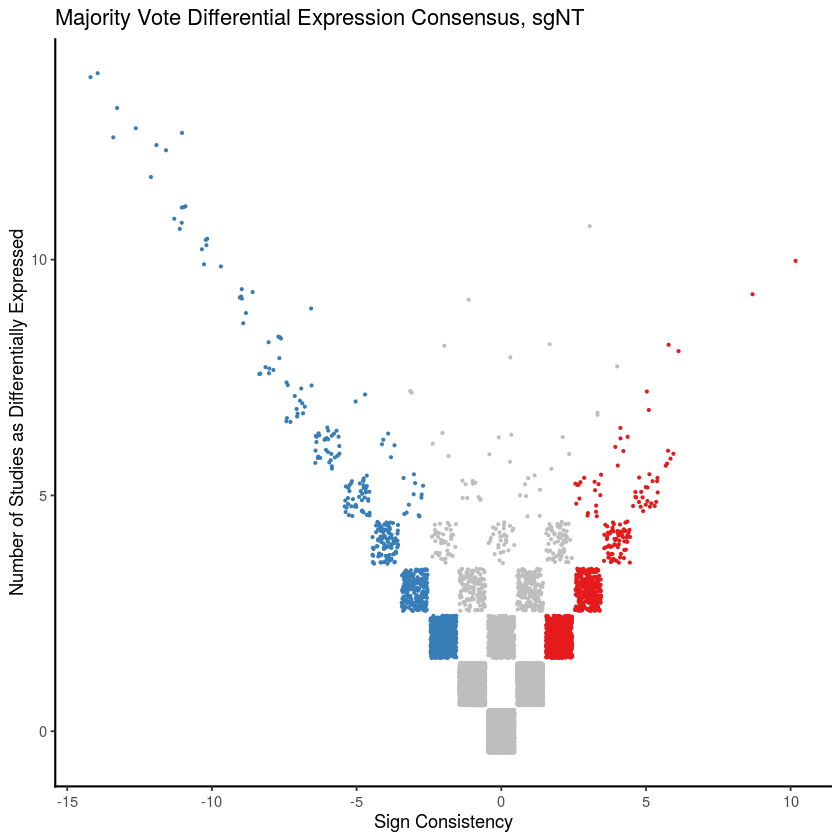

In [8]:
SIGN_CONSISTENCY = 2
SIGN_TO_FREQ = 0.5
FREQ = 0

res = meta_degs_vc@metaresult

res$ddeg = as.numeric(res$ddeg)
res$ndeg = as.numeric(res$ndeg)
res$sign_to_freq = apply(res, 1, function(x) abs(as.numeric(x[['ddeg']])) / max(1, as.numeric(x['ndeg'])) )

sig.genes = res[which(res$sign_to_freq > SIGN_TO_FREQ),]
up.genes = as.character(sig.genes[which(sig.genes$ddeg >= SIGN_CONSISTENCY),"genes"])
down.genes = as.character(sig.genes[which(sig.genes$ddeg <= (-1*SIGN_CONSISTENCY)),"genes"])

hit.genes = c(up.genes, down.genes)

rownames(res) = as.character(res$genes)

res$degvcount <- as.character(res$degvcount)
res$degvcount <- '1.Unperturbed'
res[up.genes, 'degvcount'] <-'2.Up'
res[down.genes, 'degvcount'] <- '0.Down'
res$degvcount = factor(res$degvcount, levels=c("0.Down", "1.Unperturbed", "2.Up"))
                        

g = ggplot(res, aes(x = ddeg, y = ndeg)) +
        geom_jitter(aes(color = degvcount), 
           cex=0.5, width=0.45, height=0.45) +
        labs(x = "Sign Consistency",
             y = "Number of Studies as Differentially Expressed",
            title = "Majority Vote Differential Expression Consensus, sgNT")

g + theme_classic() +
    theme(panel.border= element_blank()) +
    theme(axis.text.x = element_text(angle = 0, vjust = 0.5)) +
    theme(axis.line.x = element_line(color = "black", size = 0.6, 
                     lineend = "square"),
          axis.line.y = element_line(color = "black", size = 0.6, 
                     lineend = "square")) +
    theme(legend.position = "none") +
    scale_color_manual(values=c("#377EB8", "grey", "#E41A1C"))
                         
up.genes.df = res[up.genes, c("genes", 'ndeg', 'ddeg', 'sign_to_freq')]
colnames(up.genes.df) <- c("genes", "FreqDE", "ConsistencyDE", "ConsistencyToFreq")

down.genes.df = res[down.genes, c("genes", 'ndeg', 'ddeg', 'sign_to_freq')]
colnames(down.genes.df) <- c("genes", "FreqDE", "ConsistencyDE", "ConsistencyToFreq")

                         
print(paste0('Found ', nrow(up.genes.df), ' up-regulated genes and ', nrow(down.genes.df), ' down-regulated genes.'))

### Figure S3B - GO Analysis of up-regulated genes

Note: Please ensure that you are using msigdbr version 7.2.1, as the gene sets have changed in the most recent version of msigdbr. You can download this package from source [here](https://cran.r-project.org/src/contrib/Archive/msigdbr).

In [84]:
m_df = msigdbr(species = "Mus musculus", category = "C5", subcategory = "BP")
m_bp = m_df %>% dplyr::select(gs_name, gene_symbol) %>% as.data.frame()

In [85]:
bp.up = enricher(gene = up.genes, TERM2GENE = m_bp)

These gene sets below were hand-selected to represent the most biologically interesting gene programs at play in the positively-associated fitness genes.

In [86]:
up.programs = c("GO_RIBOSOME_BIOGENESIS",
              "GO_TRANSLATIONAL_INITIATION",
              "GO_MRNA_PROCESSING",
              "GO_STEM_CELL_DIFFERENTIATION", 
              "GO_REGULATION_OF_RESPONSE_TO_WOUNDING", 
              "GO_AMEBOIDAL_TYPE_CELL_MIGRATION",
              "GO_RIBOSE_PHOSPHATE_METABOLIC_PROCESS",
              "GO_RNA_DEPENDENT_DNA_BIOSYNTHETIC_PROCESS",
              "GO_OSSIFICATION",
              "GO_GLIAL_CELL_DEVELOPMENT",
              "GO_EPITHELIAL_CELL_PROLIFERATION",
              "GO_LAMELLIPODIUM_ORGANIZATION",
              "GO_GLIAL_CELL_DIFFERENTIATION",
              "GO_SKIN_DEVELOPMENT")

In [87]:
results = bp.up@result[up.programs, ]

results

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO_RIBOSOME_BIOGENESIS,GO_RIBOSOME_BIOGENESIS,GO_RIBOSOME_BIOGENESIS,62/1034,297/15381,5.872631e-16,1.262616e-12,1.159072e-12,Ddx27/Lyar/Fbl/Mybbp1a/Npm1/Pak1ip1/Pdcd11/Ran/Rpl12/C1qbp/Ddx18/Ddx51/Dkc1/Eif6/Emg1/Nhp2/Nob1/Nol8/Nop14/Rpf2/Rpl35a/Rps10/Rps28/Rps5/Rrs1/Abce1/Cebpz/Dis3/Ebna1bp2/Eri1/Esf1/Fcf1/Ftsj3/Gar1/Gnl2/Gtf3a/Gtpbp4/Lsm6/Mphosph10/Mrpl1/Mrto4/Nip7/Nmd3/Noc4l/Nolc1/Nom1/Nop56/Npm3/Nvl/Ppan/Rpl10a/Rpl35/Rpp38/Rps16/Rps2/Rrp15/Rrp1b/Sdad1/Tex10/Utp20/Wbp11/Wdr43,62
GO_TRANSLATIONAL_INITIATION,GO_TRANSLATIONAL_INITIATION,GO_TRANSLATIONAL_INITIATION,40/1034,183/15381,2.075142e-11,2.974371e-08,2.730451e-08,Eif1ax/Rpl32/Npm1/Rpl12/Eif4ebp1/Eif6/Pabpc1/Rpl13/Rpl28/Rpl35a/Rps10/Rps15a/Rps28/Rps5/Uba52/Abce1/Cdc123/Cops5/Ddx1/Eif2s2/Eif3c/Eif4a1/Eif4e/Eif4e2/Gle1/Ppp1r15b/Rpl10a/Rpl13a/Rpl17/Rpl18a/Rpl19/Rpl27a/Rpl30/Rpl35/Rpl8/Rps16/Rps18/Rps2/Rps23/Tpr,40
GO_MRNA_PROCESSING,GO_MRNA_PROCESSING,GO_MRNA_PROCESSING,68/1034,495/15381,1.201671e-08,4.818282e-06,4.423148e-06,Snrpg/Magohb/Pdcd11/Strap/C1qbp/Eftud2/Hnrnpf/Lgals3/Lsm3/Lsm8/Ncl/Pabpc1/Pcbp2/Prdx6/Prpf38b/Sf3a3/Snrnp25/Snrpc/Zrsr2/Adarb1/Bcas2/Cdc5l/Cdk9/Ddx1/Dnajc8/Gtf2f1/Larp7/Lsm2/Lsm5/Lsm6/Lsm7/Luc7l2/Nelfe/Pcbp1/Pnn/Pnpt1/Poldip3/Polr2b/Polr2f/Ppih/Prpf40a/Psip1/Puf60/Rbfox2/Rbm25/Rbm39/Rnmt/Rrp1b/Sf3b4/Sf3b6/Snrnp48/Snrpa/Snrpa1/Snrpb2/Snrpd1/Snrpd3/Snrpe/Snrpf/Srpk1/Srrm1/Srsf11/Tfip11/Tra2a/Wbp11/Ybx1/Ythdc1/Zc3h14/Zranb2,68
GO_STEM_CELL_DIFFERENTIATION,GO_STEM_CELL_DIFFERENTIATION,GO_STEM_CELL_DIFFERENTIATION,35/1034,264/15381,8.914728e-05,7.666666e-03,7.037943e-03,Cdk6/Hspa9/Bche/Nrp2/Nsun2/Osr1/Rdh10/Runx2/Sema4b/Cbfb/Edn1/Fzd1/Hmga2/Kitl/Lbh/Lmo1/Nolc1/Pdx1/Psma5/Psma6/Psma7/Psmc6/Psmd4/Psmd5/Psmd6/Pus7/Rbpj/Sema3e/Sema7a/Setd6/Sox21/Tcf3/Tead2/Twist1/Zfp36l2,35
GO_REGULATION_OF_RESPONSE_TO_WOUNDING,GO_REGULATION_OF_RESPONSE_TO_WOUNDING,GO_REGULATION_OF_RESPONSE_TO_WOUNDING,22/1034,171/15381,2.512020e-03,7.715491e-02,7.082764e-02,Kng2/Plaur/Spp1/Stk24/F3/Cav1/F2r/Hpse/Lrp1/Mdk/Wfdc1/Anxa2/Cd109/Dusp10/Edn1/Ephb2/Grn/Pla2g4a/Plpp3/Prdx2/Tfpi/Vil1,22
GO_AMEBOIDAL_TYPE_CELL_MIGRATION,GO_AMEBOIDAL_TYPE_CELL_MIGRATION,GO_AMEBOIDAL_TYPE_CELL_MIGRATION,41/1034,400/15381,4.595794e-03,1.135742e-01,1.042603e-01,Strap/C1qbp/Fbxw7/Fermt1/Nrp2/Pak1/Pdlim1/Pfn2/Pkn2/Rtn4/Sema4b/Amot/Dcn/Dusp10/Edn1/Fer/Fgfbp1/Gipc1/Gpi1/Grn/Hdac6/Id1/Itga3/Kitl/Krit1/Mcc/Pdcd10/Pip5k1a/Plcg2/Plpp3/Ptk2b/Rcc2/Sema3e/Sema7a/Slit2/Src/Srpx2/Svbp/Twist1/Vil1/Zfand5,41
GO_RIBOSE_PHOSPHATE_METABOLIC_PROCESS,GO_RIBOSE_PHOSPHATE_METABOLIC_PROCESS,GO_RIBOSE_PHOSPHATE_METABOLIC_PROCESS,45/1034,412/15381,8.744640e-04,4.132083e-02,3.793221e-02,Gapdh/Pkm/Tpi1/Aprt/Pgk1/Adss/Aldoa/Eno1/Pgam1/Ran/Acsl3/Aldoc/Eif6/Enpp1/Gmps/Gpat4/Impdh2/Ldha/mt-Atp6/Nme2/Pfkl/Pgm1/Pthlh/Uck2/Ak3/Atic/Cmpk1/Dlst/Gpi1/Itpa/mt-Co2/Nme1/Nt5c2/Nudt5/Nupl1/Pde4a/Pdk1/Pgm2l1/Rpia/Seh1l/Slc25a13/Tkt/Tpr/Tpst2/Upp1,45
GO_RNA_DEPENDENT_DNA_BIOSYNTHETIC_PROCESS,GO_RNA_DEPENDENT_DNA_BIOSYNTHETIC_PROCESS,GO_RNA_DEPENDENT_DNA_BIOSYNTHETIC_PROCESS,13/1034,70/15381,6.958521e-04,3.479261e-02,3.193936e-02,Cct7/Cct3/Cct8/Dkc1/Hsp90ab1/Nhp2/Tcp1/Cct2/Cct5/Gar1/Ppia/Smg5/Src,13
GO_OSSIFICATION,GO_OSSIFICATION,GO_OSSIFICATION,40/1034,394/15381,5.963451e-03,1.353225e-01,1.242251e-01,Cdk6/Fbl/Mybbp1a/Spp1/Atp2b1/Enpp1/Igfbp3/Mdk/Osr1/Phb/Pthlh/Runx2/Sgms2/Acp5/Ank/Bmp3/Cbfb/Chrd/Egfr/Esrra/Fzd1/Gtpbp4/Id1/Id2/Il6ra/Klf10/Ptger4/Ptk2b/Rbpj/Rras2/Rrbp1/Sema7a/Sh3pxd2b/Smad7/Snx10/Sox2/Twist1/Vcan/Wnt7b/Wwtr1,40


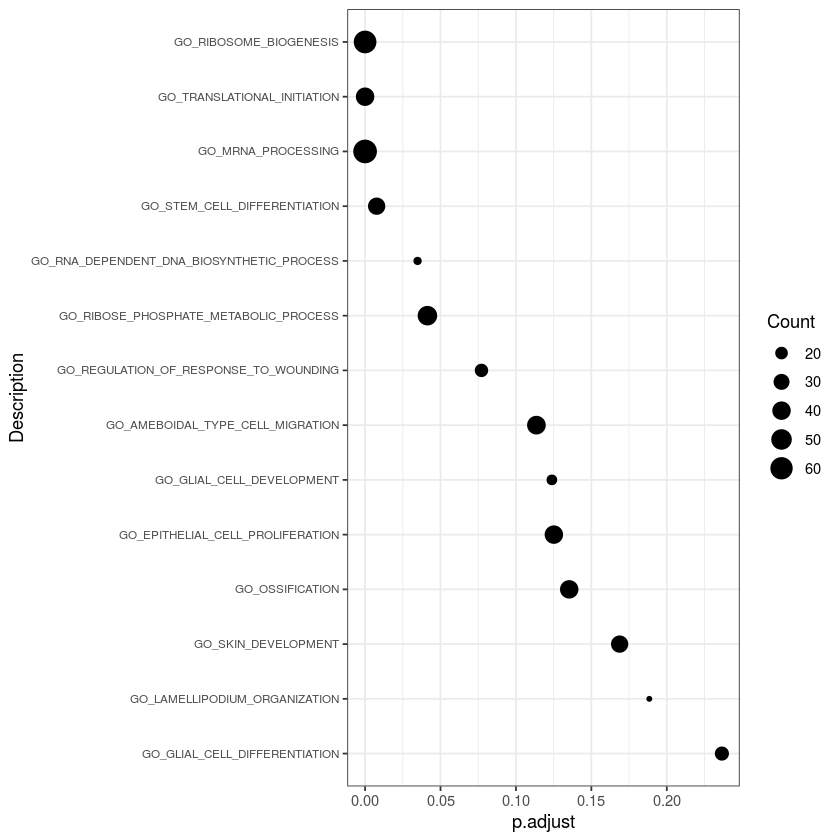

In [88]:
idx <- order(results[['p.adjust']], decreasing = F)
results$Description <- factor(results$Description,
                      levels=rev(unique(results$Description[idx])))

ggplot(results, aes_string(x='p.adjust', y="Description", size='Count')) +
    geom_point() +
    guides(size  = guide_legend(order = 1)) + 
    theme_bw() + 
    theme(axis.text.y = element_text(size = 7))

### Plot Fitness Signature against sampling time for Marjanovic et al, 2020 - Figure S3D

In [133]:
meta = read.table("./data/marjanovic_meta.tsv", sep='\t', row.names=1, header=T)
marjanovic_sigscores = read.table('./data/marjanovic_signatures.tsv', sep='\t', row.names=1, header=T)

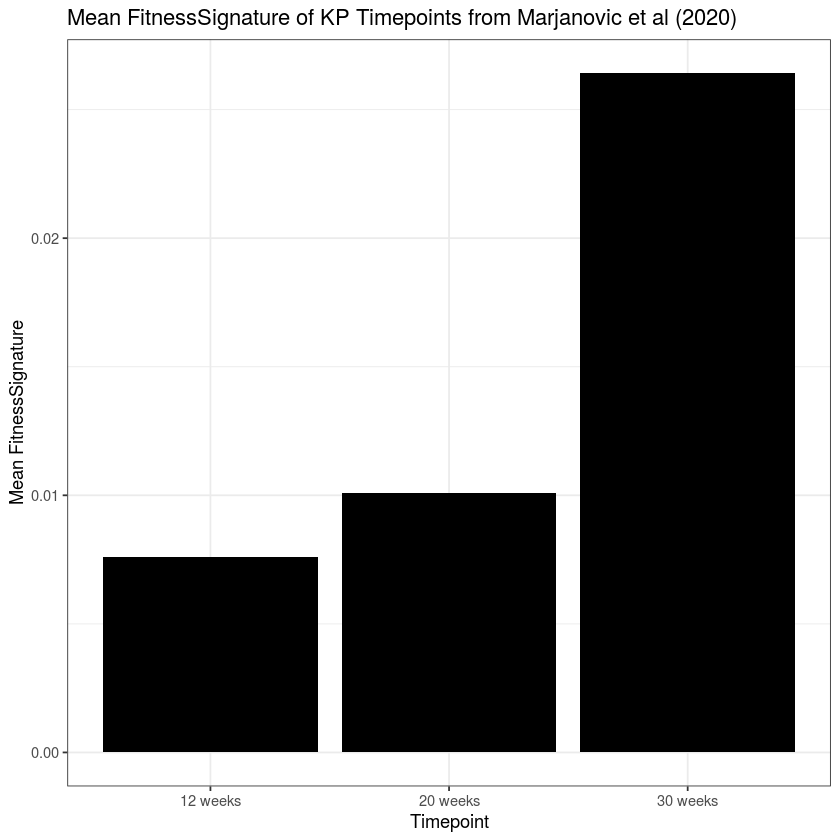

In [134]:
meta$FitnessSignature = marjanovic_sigscores[rownames(meta), 'FitnessSignature']

mean_fitnesses = meta %>%
    group_by(timesimple) %>%
    summarize(mean_fitness = mean(FitnessSignature))

mean_fitness_kp = mean_fitnesses[mean_fitnesses$timesimple %in% c('06_KP_12w_ND', '07_KP_20w_ND', '08_KP_30w_ND'),]


ggplot(mean_fitness_kp, aes(x=timesimple, y = mean_fitness))+
    geom_col(fill='black') + 
    theme_bw() +
    scale_x_discrete(breaks=c("06_KP_12w_ND","07_KP_20w_ND","08_KP_30w_ND"),
                    labels=c('12 weeks', '20 weeks', '30 weeks')) + 
    labs(y = 'Mean FitnessSignature', x = 'Timepoint', title = 'Mean FitnessSignature of KP Timepoints from Marjanovic et al (2020)')

In [90]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.6 LTS

Matrix products: default
BLAS:   /usr/lib/atlas-base/libf77blas.so.3.0
LAPACK: /usr/lib/atlas-base/atlas/liblapack.so.3.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] SuperExactTest_1.0.7  dplyr_1.0.7           cowplot_1.1.1        
 [4] enrichplot_1.12.3     clusterProfiler_4.0.5 msigdbr_7.2.1        
 [7] biomaRt_2.48.3        ggrepel_0.9.1         ggplot2_3.3.5        
[10] MetaVolcanoR_1.6.0   

loaded via a namespace (and not 